# Reconstruction of plant--pollinator networks from observational data 

A tutorial on how to use our [Stan](http://mc-stan.org) model to infer the structure and properties of real ecosystems from noisy, error-prone measurements.
Based on the article [*"Reconstruction of plant--pollinator networks from observational data"*](https://www.biorxiv.org/content/10.1101/754077v1), by [J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/).


*Author*: J.-G. Young <jgyou@umich.edu> <br/>
*Date*: July 2019

---

**Important Note:** In this notebook, I assume that you have installed `pystan` and will interact with the model in `python3` (check the [README](README.md) file otherwise). `Stan` also has a [R interface](https://cran.r-project.org/web/packages/rstan/index.html), for which we do not provide helper functions.
That said, all what we show here should easily be transferable to the `R` version of `Stan`!
The only purpose of our python code is to manipulate the samples once they have been generated by `Stan`.

---

## Loading data and modules

First, let's import some required modules: 'pystan `numpy` and `pyplot` to handle the model the data and visualize our results.
We'll also import the custom helper modules `utilities` (load / save / compress / sort data matrices) and `plant_pol_inference` (interact with model, draw samples, compute estimates).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import utilities as ut
import plant_pol_inference as pp

In [2]:
import scipy.sparse as sparse

def read_edges_to_sparse_adjacency(filename):
    """
    Reads a .edges file and returns a sparse adjacency matrix.

    Args:
        filename (str): The path to the .edges file.  Assumes each line
                      represents an edge as "node1 node2", where node1
                      and node2 are integer node IDs starting from 1.

    Returns:
        scipy.sparse.csr_matrix: A sparse CSR (Compressed Sparse Row) adjacency matrix.
                                  Returns None if there's an error reading the file.
    """
    edges = []
    max_node_id = 0

    try:
        with open(filename, 'r') as f:
            for line in f:
                # Split the line into node IDs (assuming space-separated)
                parts = line.strip().split()
                if len(parts) != 2:
                    print(f"Warning: Skipping malformed line: {line.strip()}")
                    continue # Skip lines that don't have two values
                try:
                    node1, node2 = map(int, parts)
                except ValueError:
                    print(f"Warning: Skipping line due to invalid node IDs: {line.strip()}")
                    continue
                edges.append((node1, node2))
                max_node_id = max(max_node_id, node1, node2)  # Keep track of the largest node ID

    except FileNotFoundError:
        print(f"Error: File not found: {filename}")
        return None
    except Exception as e:
        print(f"Error reading file {filename}: {e}")
        return None

    # Create the sparse adjacency matrix
    num_nodes = max_node_id  # Number of nodes based on largest ID
    adj_matrix = sparse.lil_matrix((num_nodes, num_nodes), dtype=np.int8)  # Use LIL for efficient construction

    # Populate the adjacency matrix
    for node1, node2 in edges:
        # Adjust indices to be 0-based for the matrix
        adj_matrix[node1 - 1, node2 - 1] = 1
        adj_matrix[node2 - 1, node1 - 1] = 1  # Assuming undirected graph

    # Convert to CSR format for efficient operations
    return adj_matrix.tocsr()

In [3]:
# --- Example Usage ---
filename = "eco-foodweb-baydry.edges"  # Replace with your filename
M = read_edges_to_sparse_adjacency(filename)

Let's try again with .txt file

In [4]:
def read_edgelist_to_sparse_adjacency(filename, delimiter=None, comment_char="#", header_lines=0):
    """
    Reads an edgelist from a .txt file and returns a sparse adjacency matrix.

    Args:
        filename (str): The path to the .txt file containing the edgelist.
        delimiter (str, optional): The delimiter used to separate node IDs on each line.
                                   Defaults to None (whitespace). Common values: ',', '\t'.
        comment_char (str, optional): Character that indicates a comment line to be skipped.
                                      Defaults to "#".  Set to None to disable comment handling.
        header_lines (int, optional): Number of lines to skip at the beginning of the file.
                                       Defaults to 0.

    Returns:
        scipy.sparse.csr_matrix: A sparse CSR (Compressed Sparse Row) adjacency matrix.
                                  Returns None if there's an error reading the file.
    """
    edges = []
    max_node_id = 0

    try:
        with open(filename, 'r') as f:
            # Skip header lines
            for _ in range(header_lines):
                next(f)

            for line_num, line in enumerate(f, start=header_lines + 1): # Track line number
                line = line.strip()

                # Skip comment lines
                if comment_char and line.startswith(comment_char):
                    continue

                # Skip empty lines
                if not line:
                    continue

                parts = line.split(delimiter)
                if len(parts) != 2:
                    print(f"Warning: Skipping line {line_num} due to incorrect number of fields: {line}")
                    continue

                try:
                    node1, node2 = map(int, map(str.strip, parts)) # Strip whitespace from each part
                except ValueError:
                    print(f"Warning: Skipping line {line_num} due to invalid node IDs: {line}")
                    continue

                edges.append((node1, node2))
                max_node_id = max(max_node_id, node1, node2)

    except FileNotFoundError:
        print(f"Error: File not found: {filename}")
        return None
    except Exception as e:
        print(f"Error reading file {filename}: {e}")
        return None

    # Create the sparse adjacency matrix
    num_nodes = max_node_id
    adj_matrix = sparse.lil_matrix((num_nodes, num_nodes), dtype=np.int8)

    # Populate the adjacency matrix (assuming undirected)
    for node1, node2 in edges:
        adj_matrix[node1 - 1, node2 - 1] = 1
        adj_matrix[node2 - 1, node1 - 1] = 1

    return adj_matrix.tocsr()

In [6]:
# --- Example Usage ---
filename = "eco-foodweb-baydry.txt"  # Replace with your .txt file
delimiter = None  # Or e.g., "," if comma-separated
comment_char = "#"  # Or None if no comments
header_lines = 0 # Or the number of header lines to skip

adj_matrix = read_edgelist_to_sparse_adjacency(filename, delimiter, comment_char, header_lines)


Let's try to refine the function

In [7]:
def read_weighted_edgelist_to_sparse_adjacency(filename, delimiter=None, comment_char="#"):
    """
    Reads a weighted edgelist from a text file and returns a sparse adjacency matrix.

    Args:
        filename (str): The path to the edgelist file. Assumes each data line
                        has format "node1 node2 weight", separated by whitespace.
        delimiter (str, optional): The delimiter used to separate fields on each line.
                                   Defaults to None (whitespace). Common values: ',', '\t'.
        comment_char (str, optional): Character that indicates a comment line to be skipped.
                                      Defaults to "#". Set to None to disable comment handling.

    Returns:
        scipy.sparse.csr_matrix: A sparse CSR (Compressed Sparse Row) adjacency matrix
                                  representing the directed, weighted graph. Returns None if
                                  the file cannot be read or contains no valid edges.
        int: The maximum node ID found. This is used as the dimension for the square matrix.
    """
    edges = [] # To store (node1, node2, weight)
    max_node_id = 0

    try:
        with open(filename, 'r') as f:
            for line_num, line in enumerate(f, start=1): # 1-based line number
                line = line.strip()

                # Skip empty lines
                if not line:
                    continue

                # Skip comment lines based on the specified character
                if comment_char and line.startswith(comment_char):
                    # Optional: print skipped comments for verification
                    # print(f"Skipping comment line {line_num}: '{line}'")
                    continue

                # Process data lines
                parts = line.split(delimiter)

                # We expect exactly 3 fields for a weighted edge list (node1, node2, weight)
                if len(parts) != 3:
                    print(f"Warning: Skipping data line {line_num} due to incorrect number of fields (expected 3, got {len(parts)}): '{line}'")
                    continue

                try:
                    # Strip whitespace from each part and convert types
                    node1 = int(parts[0].strip())
                    node2 = int(parts[1].strip())
                    weight = float(parts[2].strip())
                except ValueError:
                    print(f"Warning: Skipping data line {line_num} due to invalid node ID or weight format: '{line}'")
                    continue
                except Exception as e:
                     # Catch any other unexpected errors during parsing
                     print(f"Warning: Skipping data line {line_num} due to unexpected parsing error: '{line}' - {e}")
                     continue

                # Basic validation for node IDs (must be positive for 1-based indexing)
                if node1 <= 0 or node2 <= 0:
                     print(f"Warning: Skipping data line {line_num} due to non-positive node ID: '{line}'")
                     continue

                # Store the edge information
                edges.append((node1, node2, weight))
                # Update max node ID seen to determine matrix dimensions
                max_node_id = max(max_node_id, node1, node2)

    except FileNotFoundError:
        print(f"Error: File not found: {filename}")
        return None, 0 # Return None and 0 nodes on error
    except Exception as e:
        print(f"Error reading file {filename}: {e}")
        return None, 0 # Return None and 0 nodes on error

    if not edges:
        print("No valid data lines found in the file after processing comments and filtering malformed lines.")
        return None, 0 # Return None and 0 nodes if no valid edges were found

    # Determine the size of the adjacency matrix. Use max_node_id
    # to ensure the matrix is large enough to include all node IDs found.
    num_nodes = max_node_id
    print(f"Successfully read {len(edges)} edges.")
    print(f"Max node ID found: {max_node_id}. Creating a {num_nodes}x{num_nodes} matrix.")
    # The comment "% 2137 128 128" suggests 128 is indeed the total number of nodes.

    # Create the sparse adjacency matrix (assuming directed, weighted)
    # Use dtype=float to store weights (the weights are floating point numbers)
    # Use LIL format for efficient step-by-step construction
    adj_matrix = sparse.lil_matrix((num_nodes, num_nodes), dtype=float)

    # Populate the adjacency matrix with weights
    for node1, node2, weight in edges:
        # Adjust node IDs to be 0-based indices for the matrix
        # Based on the 'asym posweighted' comment, assuming a directed edge from node1 to node2
        # with the specified weight.
        adj_matrix[node1 - 1, node2 - 1] = weight

    # Convert the LIL matrix to CSR format for efficient downstream operations
    return adj_matrix.tocsr(), num_nodes # Return the matrix and the number of nodes


In [11]:
filename = "eco-foodweb-baydry.txt"  # <-- Make sure this is the correct path to your file
delimiter = None       # Use whitespace as delimiter (split() with None handles multiple spaces)
comment_char = "#"     # Lines starting with '%' are comments

In [12]:
# Call the function to load the weighted adjacency matrix
weighted_adj_matrix, total_num_nodes_in_network = read_weighted_edgelist_to_sparse_adjacency(filename, delimiter, comment_char)


Successfully read 2137 edges.
Max node ID found: 128. Creating a 128x128 matrix.


In [18]:
weighted_adj_matrix.toarray()

array([[ 0.      ,  1.261404, 21.9353  , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [19]:
M = weighted_adj_matrix.toarray()

Since the original code and methods were developed for counting data, we transform the float edges into integers

In [21]:
M=M.astype(int)

In [25]:
np.diag(M)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:

M = ut.sort(M, M)
n_p = M.shape[0]
n_a = M.shape[1]

In [23]:
n_p

128

In [24]:
n_a

128

Let's visualize it:

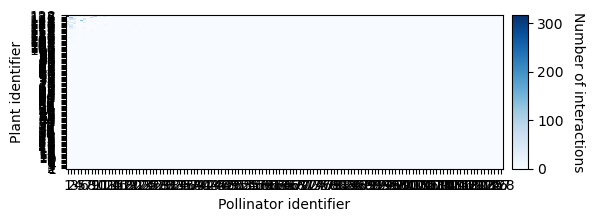

In [26]:
plt.figure(figsize=(6,2))
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier')
plt.ylabel('Plant identifier')
plt.show()

## Pystan model

In `pystan`, we write the statistical model in a separate file.
In our case, it looks like:

In [27]:
with open('model.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  int<lower=0> M[n_p, n_a];
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  int M_rows[n_p] = rep_array(0, n_p);
  int M_cols[n_a] = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      real nu_ij_0 = log(1 - rho);
      real nu_ij_1 = log(rho) + M[i,j] * log(1 + r) - C * r * sigma[i] * t

The `data` block contains the model parameters, in our case the dimension of the observation matrix, and the matrix itself.

The `transformed data` block allows us to calculate quantities that we'll use later. Here, we calculate the row and column sums of M, as well as its total sum.

The `parameter` block contains... well.. the parameters of the model.
These parameters are the ones that will be sampled by `Stan`, and returned to us  once we run the program.
`sigma` and `tau` are of the "simplex" type---just a synonym for normalized distributions.

The `model` block calculates the log-posterior of the model. We accumulate this value in the variable `target`.

The `generated quantities` block contains other quantities, functions of the sampled parameters, that will be returned to us once we run the program. In this case, we generate the matrix Q of edge probabilities given the parameters.

---

## Compiling the model

To  start using the model, we first need to "compile" it.
During compilation, `pystan` builds an executable whose purpose is to generate samples from our model, given an input.
Compilation takes a bit of time, but we only need to compile the model once. We are free to re-use it as many times as we like afterwards.

Our module `plant_pol_inference` (imported as `pp`) provides utilities to handle this.

In [28]:
model = pp.load_model()

c:\Users\hugog\Desktop\Master_Courses\Complex_Networks\Project\jg-you-plant-pollinator-inference-1541aeb\model.bin [Skipping --- already compiled]


## Sampling

With the model compiled, we are ready to generate our first samples.

Our `plant_pol_inference` module also provide utilities that handle this.

In [29]:
samples = pp.generate_sample(M, model, warmup=2000, num_samples=500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


The warnings above indicate that at least one chain has gotten stuck in a minima.

We can see this by plotting the value of the posterior distribution, evaluated for each samples.

Note that in this plot, vertical lines separate Markov chains: All samples between two of these lines are generated sequentially, by an independent chain.

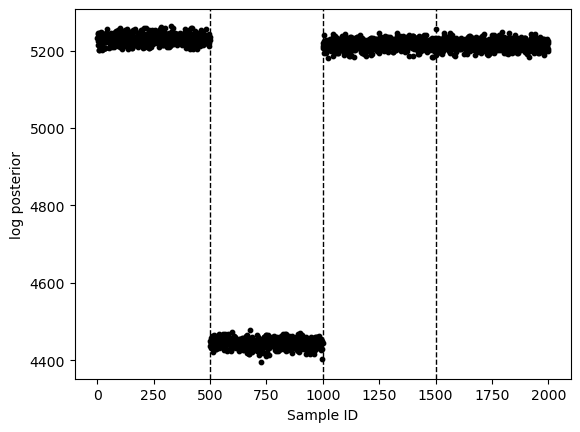

In [31]:
plt.scatter(range(2000), samples['lp__'], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')
plt.show()

Not needed given the diagnostic analysis results

while not pp.test_samples(samples, tol=0.05):
    samples = pp.generate_sample(M, model, warmup=2000, num_samples=500)

plt.scatter(range(2000), samples['lp__'], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')
plt.show()

Here's the summary of our succesful sampling procedure:

In [32]:
samples


For the full summary use 'print(fit)'

Inference for Stan model: plant_pol_e215d9f28a31a5a7790444e1b0d7f7ff.
4 chains, each with iter=2500; warmup=2000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C         189.92     nan  263.8  22.01  33.26  42.05 331.97 679.49    nan    nan
r         1378.0     nan 811.44 262.41 604.66 1383.5 1876.3 3113.2    nan    nan
sigma[1]  4.0e-3     nan 4.8e-3 7.1e-5 7.9e-4 2.3e-3 5.2e-3   0.02    nan    nan
sigma[2]  4.0e-3     nan 5.2e-3 5.7e-5 7.2e-4 2.1e-3 5.3e-3   0.02    nan    nan
sigma[3]  4.2e-3     nan 5.4e-3 5.1e-5 7.0e-4 2.1e-3 5.5e-3   0.02    nan    nan
sigma[4]  4.0e-3     nan 4.8e-3 4.5e-5 8.1e-4 2.2e-3 5.3e-3   0.02    nan    nan
sigma[5]  4.0e-3     nan 4.9e-3 6.7e-5 7.9e-4 2.1e-3 5.3e-3   0.02    nan    nan
sigma[6]  4.0e-3     nan 4.8e-3 7.1e-5 8.0e-4 2.2e-3 5.4e-3   0.02    nan    nan
sigma[7]  4.0e-3     nan 5.0e-3 5.7e-5 7.1e-

## Posterior-predictive check

We provide a simple function that calculates the posterior predictive matrix.

In [33]:
M_tilde = pp.get_posterior_predictive_matrix(samples)

Let's compare it with the input

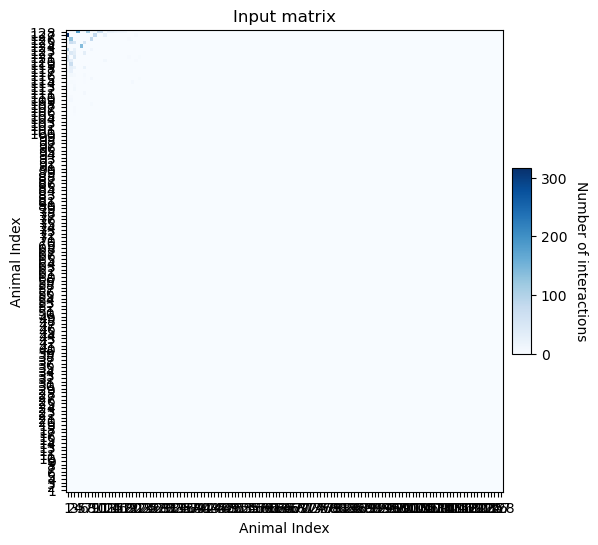

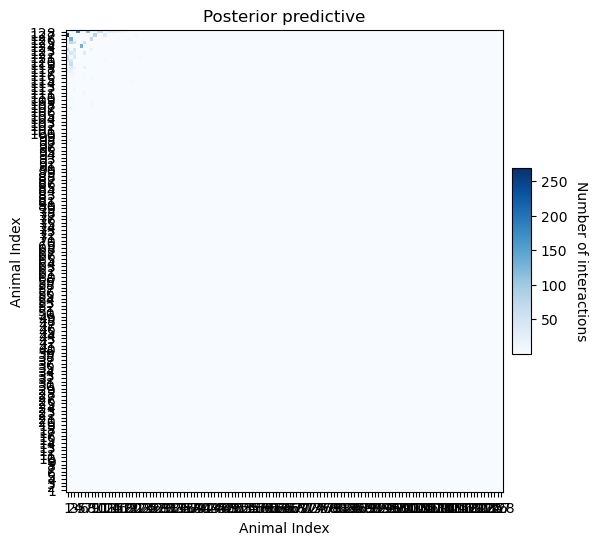

In [37]:
plt.figure(figsize=(6,6))
plt.title('Input matrix')
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.figure(figsize=(6,6))
plt.title('Posterior predictive')
plt.pcolormesh(M_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.show()


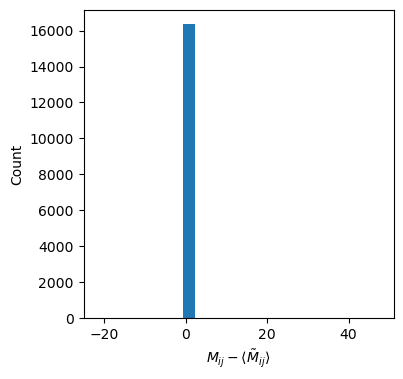

In [35]:
plt.figure(figsize=(4,4))
plt.hist((M-M_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$M_{ij}-\langle \tilde{M}_{ij}\rangle$')
plt.ylabel('Count')
plt.show()

Or compare the posterior predictive value to the input directly:

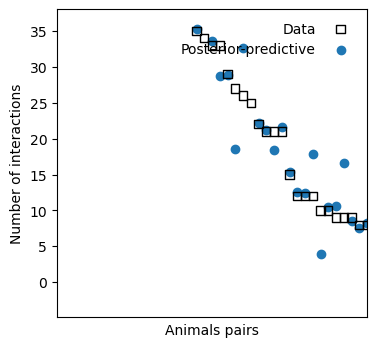

In [38]:
plt.figure(figsize=(4,4))
sort_order = np.argsort(-M.flatten())

plt.scatter(range(1, len(sort_order)+1), M.flatten()[sort_order], marker='s', facecolors='none', edgecolors='k', label='Data')
plt.scatter(range(1, len(sort_order)+1), M_tilde.flatten()[sort_order], label='Posterior-predictive', zorder=-10)

plt.xlim(0,40)
plt.xlabel('Animals pairs')
plt.xticks([])
plt.ylabel(r'Number of interactions')
plt.legend(frameon=False, markerfirst=False, loc=1)
plt.ylim(-4.9,38)
plt.show()

All these point of view confirm one thing: The model fits well.

Which means we're ready to calculate some estimates.

## Estimates

We provide a simple function to get the network estimate:

In [39]:
edge_prob = pp.estimate_network(samples)

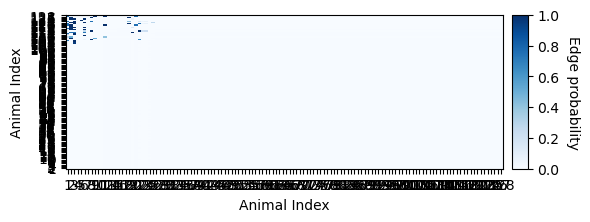

In [40]:
plt.figure(figsize=(6,2))

plt.pcolormesh(edge_prob, cmap=plt.cm.Blues, vmin=0, vmax=1)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge probability', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.show()


In [42]:
def plot_subset_interaction_matrices(M, M_tilde, edge_prob, n_p, n_a, subset_n_p, subset_n_a):
    """
    Plots subsets of interaction and edge probability matrices for randomly selected 
    plants and pollinators.

    Args:
        M: Full input interaction matrix.
        M_tilde: Full posterior predictive interaction matrix.
        edge_prob: Full edge probability matrix.
        n_p: Total number of plants.
        n_a: Total number of pollinators.
        subset_n_p: Number of plants to include in the subset plot.
        subset_n_a: Number of pollinators to include in the subset plot.
    """

    if subset_n_p > n_p:
        print(f"Warning: subset_n_p ({subset_n_p}) is larger than n_p ({n_p}). Using n_p instead.")
        subset_n_p = n_p
    if subset_n_a > n_a:
        print(f"Warning: subset_n_a ({subset_n_a}) is larger than n_a ({n_a}). Using n_a instead.")
        subset_n_a = n_a
    if subset_n_p <= 0 or subset_n_a <= 0:
        print("Error: Subset sizes must be positive.")
        return

    # --- Randomly select indices for plants and pollinators ---
    # Use replace=False to ensure unique indices
    plant_indices = np.sort(np.random.choice(range(n_p), size=subset_n_p, replace=False))
    pollinator_indices = np.sort(np.random.choice(range(n_a), size=subset_n_a, replace=False))

    # --- Extract the sub-matrices using the selected indices ---
    # np.ix_ is useful for creating index arrays for sub-matrix selection
    ixgrid = np.ix_(plant_indices, pollinator_indices)
    M_sub = M[ixgrid]
    M_tilde_sub = M_tilde[ixgrid]
    edge_prob_sub = edge_prob[ixgrid]

    # --- Define original labels for the selected subset ---
    plant_labels = plant_indices + 1  # Original identifiers (1-based)
    pollinator_labels = pollinator_indices + 1 # Original identifiers (1-based)

    # --- Helper function for plotting a single matrix subset ---
    def plot_single_subset(matrix_sub, title, colorbar_label, cmap, vmin=None, vmax=None):
        plt.figure(figsize=(6, max(2, 6 * subset_n_p / subset_n_a))) # Adjust aspect ratio
        plt.title(title)
        
        # Use imshow for potentially non-uniform grids or pcolormesh if preferred
        # Using pcolormesh as in the original example
        plt.pcolormesh(matrix_sub, cmap=cmap, vmin=vmin, vmax=vmax)
        
        cb = plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
        cb.ax.get_yaxis().labelpad = 15
        cb.set_label(colorbar_label, rotation=270)
        
        # Set ticks based on the subset size and labels based on original IDs
        plt.yticks(np.arange(subset_n_p) + 0.5, plant_labels)
        plt.xticks(np.arange(subset_n_a) + 0.5, pollinator_labels, rotation=90) # Rotate if many labels
        
        plt.xlabel('Animal identifier')
        plt.ylabel('Animal identifier')
        plt.tight_layout() # Adjust layout to prevent labels overlapping

    # --- Plot the subsets ---
    plot_single_subset(M_sub, 'Input matrix (Subset)', 'Number of interactions', plt.cm.Blues)
    plot_single_subset(M_tilde_sub, 'Posterior predictive (Subset)', 'Number of interactions', plt.cm.Blues)
    plot_single_subset(edge_prob_sub, 'Edge probability (Subset)', 'Edge probability', plt.cm.Blues, vmin=0, vmax=1)

    plt.show()

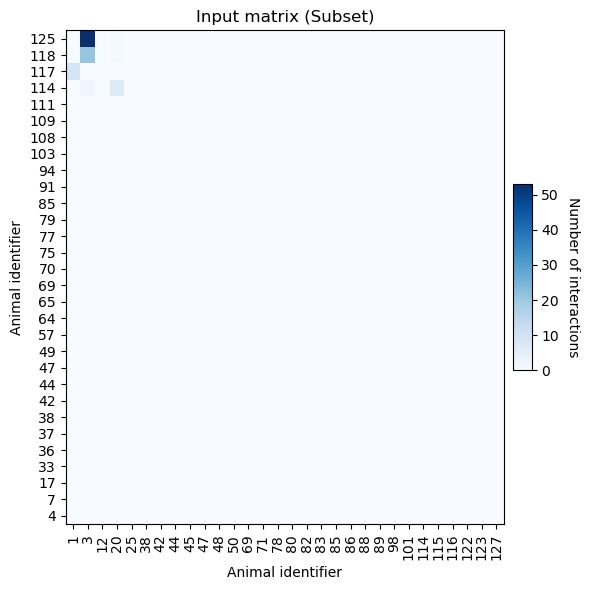

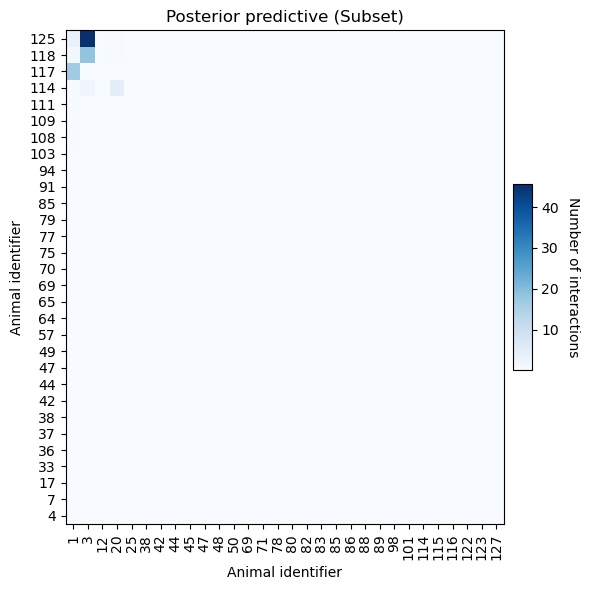

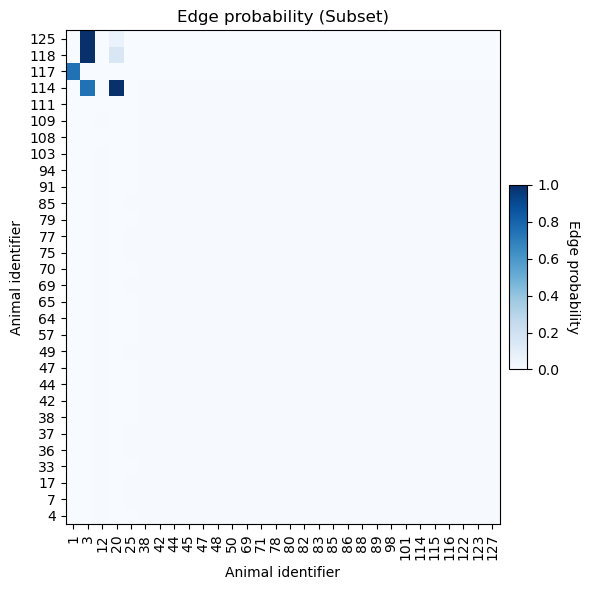

In [44]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
plot_subset_interaction_matrices(
    M, 
    M_tilde, 
    edge_prob, 
    n_p, 
    n_a, 
    subset_animals, 
    subset_animals
)

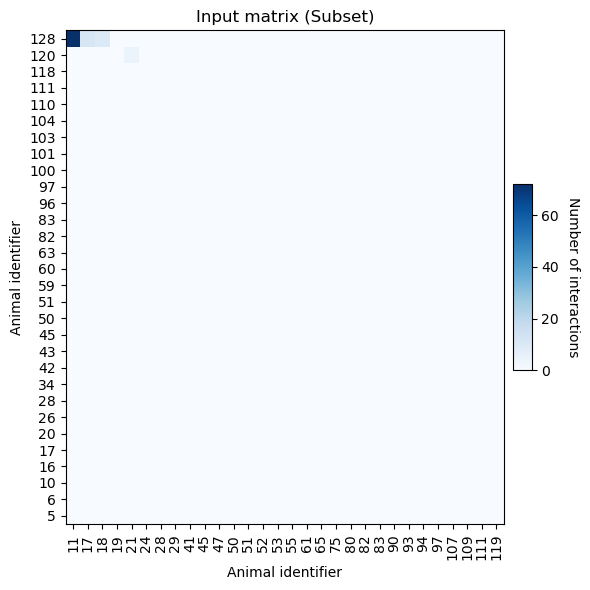

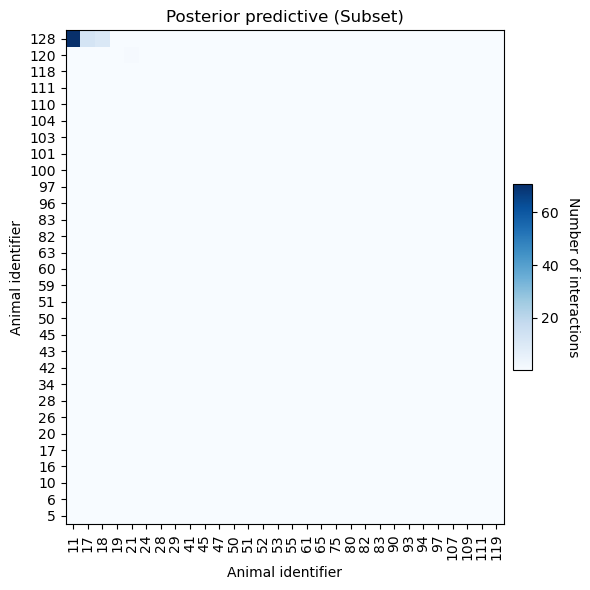

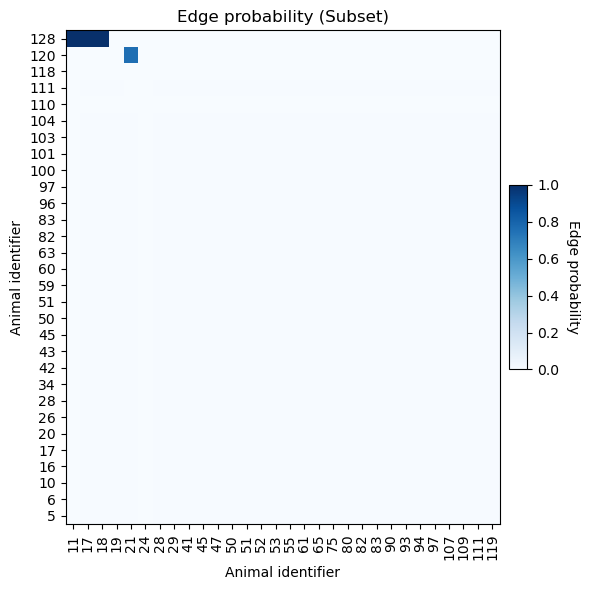

In [45]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
plot_subset_interaction_matrices(
    M, 
    M_tilde, 
    edge_prob, 
    n_p, 
    n_a, 
    subset_animals, 
    subset_animals
)

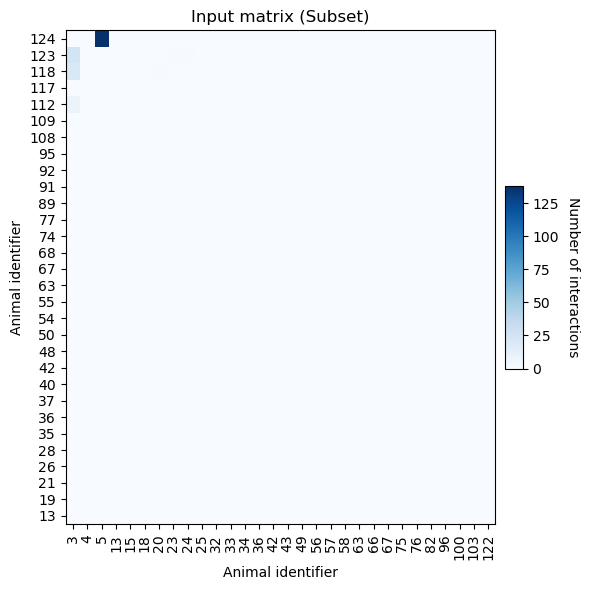

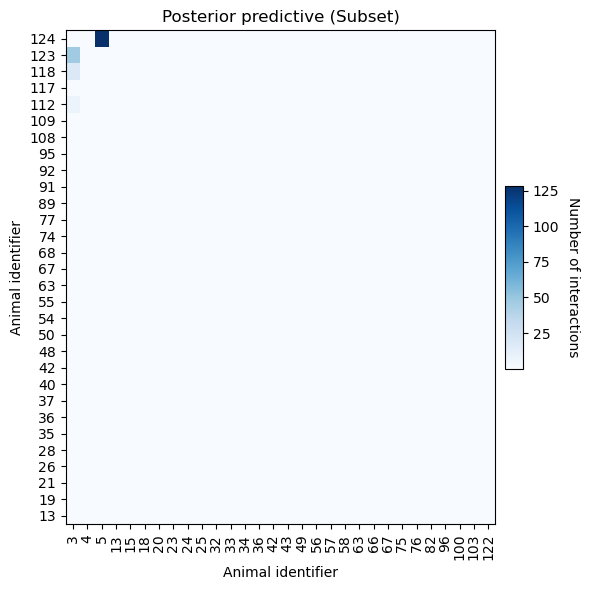

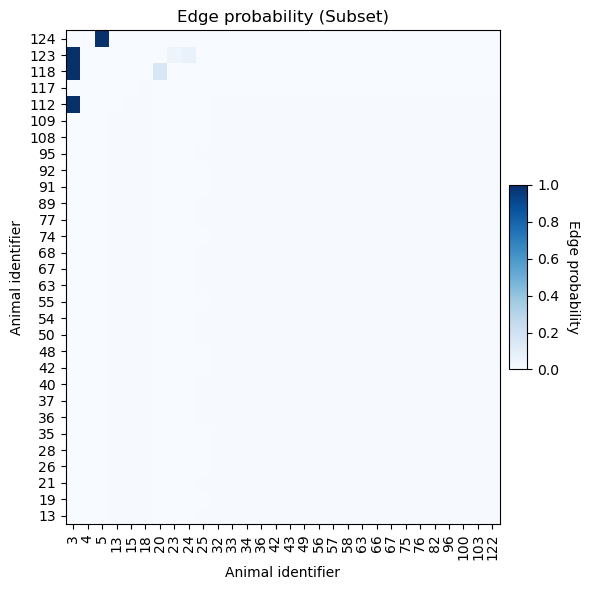

In [47]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
plot_subset_interaction_matrices(
    M, 
    M_tilde, 
    edge_prob, 
    n_p, 
    n_a, 
    subset_animals, 
    subset_animals
)

The parameters themselves are contained in the `samples` object:

In [48]:
samples['rho']

array([0.00997146, 0.00911691, 0.01041035, ..., 0.00492511, 0.00692648,
       0.00812682])

So we can, for example, visualize posterior distributions as:

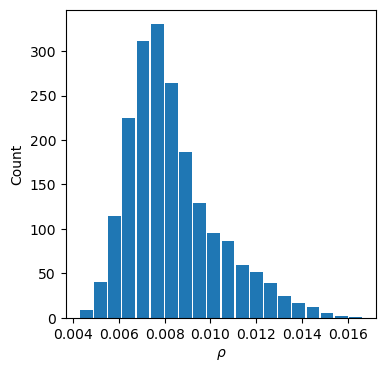

In [49]:
plt.figure(figsize=(4,4))
plt.hist(samples['rho'], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\rho$')
plt.ylabel('Count')
plt.show()

And find posterior averages with:

In [50]:
print('Posterior average of the connectance:', np.mean(samples['rho'], axis=0))

Posterior average of the connectance: 0.008345430082876217


The same thing goes for, say, the plant abundances (now a dimension `samples * n_p` object---hence why we average along the axis 0, the `samples` axis):

In [51]:
mean_sigma = np.mean(samples['sigma'], axis=0)

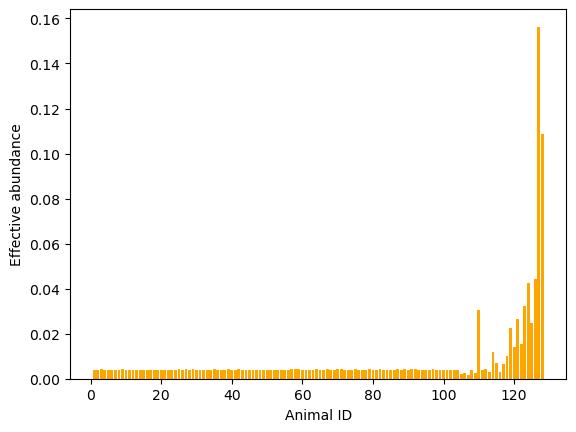

In [52]:
plt.bar([i + 1 for i in range(n_p)], mean_sigma, color='orange')
plt.xlabel('Animal ID')
plt.ylabel('Effective abundance')
plt.show()

We can do the same with the pollinators:

In [53]:
mean_tau = np.mean(samples['tau'], axis=0)

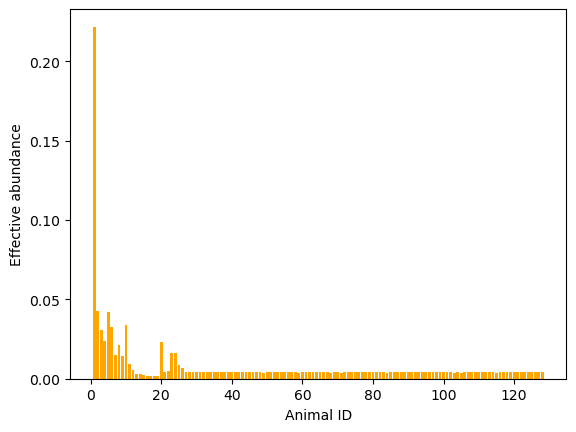

In [54]:
plt.bar([i + 1 for i in range(n_a)], mean_tau, color='orange')
plt.xlabel('Animal ID')
plt.ylabel('Effective abundance')
plt.show()

The last thing we'll calculate is the posterior distribution of **some arbitrary function** of the incidence matrix.

To make this example simple, we'll consider the number of non-zero entries, i.e.,

$$f(B) = \sum_{ij} B_{ij}$$

The python definition of this function is simple:

In [55]:
def edge_sum(B):
    return np.sum(B)

Again, we provide a simpler interface to make the calculation:

In [56]:
posterior_values_edge_sum = pp.get_network_property_distribution(samples, edge_sum)

We find, in this case:

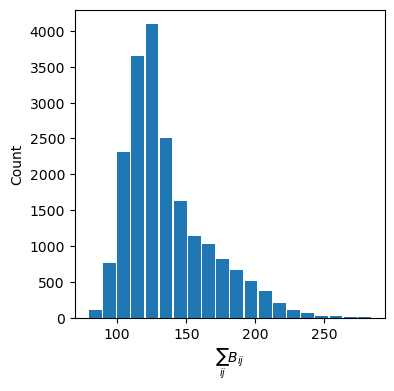

In [57]:
plt.figure(figsize=(4,4))
plt.hist(posterior_values_edge_sum, density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\sum_{ij} B_{ij}$')
plt.ylabel('Count')
plt.show()